# Тестовое задание

Задача exploration data analysis. Часто, когда мы запустили новую фичу в продукте или запускаем новый продукт целиком мы можем не знать, как пользователи внутри приложения ведут себя. Задача eda заключается в исследовании данных и построении выводов. Вам предлагается исследовать заказы и найти интересные факты, а также ответить на конкретные вопросы бизнеса. Прелесть этого задания в том, что в данных могут быть проблемы, обрати на это внимание - часто во время учебы мы получаем готовые результаты - хорошие обработанные файлы, однако на практике все совсем не так, данные могут быть действительно “грязными”.


В папке с заданием два датасета - data_orders - содержит выборку данных по заказам клиентов и включает такие колонки как:
* order_datetime -  время заказа
* order_gk - номер заказа
* order_status_key - статус (4 - отменен клиентом, 9 - отменен системой (reject))
* is_courier_assigned_key - был ли назначен курьер
* cancellations_time_in_seconds - сколько секунд прошло до отмены

data_offers - содержит пары номер заказа - ID оффера, который был предложен курьеру по данному заказу.


В момент когда клиент нажимает на кнопку "Заказать" в приложении, система матчинга подыскивает наиболее релевантых курьеров и предлагаем им заказ. В задании предлагается исследовать некоторые метрики неудачных заказов

Задание является проверочным и не имеет ничего общего с реальной работой курьеров

## Подготовка данных, проверка выбросов, аномалий

In [1]:
## CODE HERE
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore')

In [2]:
#открываем файл data_orders и смотрим св-ва датасета
#опишите основные статистики датасета и его особенности
df_orders = pd.read_csv('data_orders.csv')
#далее ваш код
df_orders.head(10)

,order_datetime,order_gk,order_status_key,is_courier_assigned_key,cancellations_time_in_seconds
0,2020-07-22 18:08:07,3000583041974,4,1,198.0
1,2020-07-22 20:57:32,3000583116437,4,0,128.0
2,2020-07-22 12:07:50,3000582891479,4,1,46.0
3,2020-07-22 13:50:20,3000582941169,4,1,62.0
4,2020-07-22 21:24:45,3000583140877,9,0,NaN
5,2020-07-22 21:21:23,3000583117054,9,0,NaN
6,2020-07-22 07:58:15,3000582791789,9,0,NaN
7,2020-07-22 07:53:46,3000582791562,9,0,NaN
8,2020-07-22 08:53:01,3000582817606,9,0,NaN
9,2020-07-22 06:33:52,3000582765616,4,0,78.0


С первого взгляда на датасет, сразу видно много пропусков в столбце cancellations_time_in_seconds - сколько секунд прошло до отмены. А так же можно заметить, что эти пропуски соответствуют статусу - 9- отменен системой. Проверим таблицу на пропуски и дубликаты.

In [3]:
def inspect(df_orders):
    display(df_orders.head()) 
    df_orders.info() 
    print ('Количество дубликатов -', df_orders.duplicated().sum())
    print ('Количество NaN  - ', df_orders.isna().sum())
    print ('Количество дубликатов в order_gk - ', df_orders['order_gk'].duplicated().sum())
    print('Количество NaN в cancellations_time_in_seconds', df_orders['cancellations_time_in_seconds'].isna().sum())
    print('Количество NaN в order_datetime', df_orders['order_datetime'].isna().sum())
    numeric_columns=df_orders.describe().columns
    display(df_orders.describe())
    display()
   
    return df_orders
df = inspect(df_orders)

,order_datetime,order_gk,order_status_key,is_courier_assigned_key,cancellations_time_in_seconds
0,2020-07-22 18:08:07,3000583041974,4,1,198.0
1,2020-07-22 20:57:32,3000583116437,4,0,128.0
2,2020-07-22 12:07:50,3000582891479,4,1,46.0
3,2020-07-22 13:50:20,3000582941169,4,1,62.0
4,2020-07-22 21:24:45,3000583140877,9,0,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_datetime                 10716 non-null  object 
 1   order_gk                       10716 non-null  int64  
 2   order_status_key               10716 non-null  int64  
 3   is_courier_assigned_key        10716 non-null  int64  
 4   cancellations_time_in_seconds  7307 non-null   float64
dtypes: float64(1), int64(3), object(1)
memory usage: 418.7+ KB
Количество дубликатов - 0
Количество NaN  -  order_datetime                      0
order_gk                            0
order_status_key                    0
is_courier_assigned_key             0
cancellations_time_in_seconds    3409
dtype: int64
Количество дубликатов в order_gk -  0
Количество NaN в cancellations_time_in_seconds 3409
Количество NaN в order_datetime 0


,order_gk,order_status_key,is_courier_assigned_key,cancellations_time_in_seconds
count,1.071600e+04,10716.000000,10716.000000,7307.000000
mean,3.000598e+12,5.590612,0.262598,157.892021
std,2.396261e+07,2.328845,0.440066,213.366963
min,3.000550e+12,4.000000,0.000000,3.000000
25%,3.000583e+12,4.000000,0.000000,45.000000
50%,3.000595e+12,4.000000,0.000000,98.000000
75%,3.000623e+12,9.000000,1.000000,187.500000
max,3.000633e+12,9.000000,1.000000,4303.000000


3409пропусков - это 31.2% пропусков по этой колонке датасета. В колонке cancellations_time_in_seconds есть выбросы - max значение-4303, тогда как среднее -213, а медиана 157

Изменим тип данных в колонке со временем.
Далее проверим общее количество строк в отмененных системой заказах и сопоставим цифру с пропусками.

In [4]:
df_orders['order_datetime'] = pd.to_datetime(df_orders['order_datetime'])
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_datetime                 10716 non-null  datetime64[ns]
 1   order_gk                       10716 non-null  int64         
 2   order_status_key               10716 non-null  int64         
 3   is_courier_assigned_key        10716 non-null  int64         
 4   cancellations_time_in_seconds  7307 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 418.7 KB


In [5]:
gr_9=df_orders.query('order_status_key==9')
print('Количество NaN в cancellations_time_in_seconds', gr_9['cancellations_time_in_seconds'].isna().sum())
print('Количество строк в отмененных заказах системой',len(gr_9))

Количество NaN в cancellations_time_in_seconds 3409
Количество строк в отмененных заказах системой 3409


Получается нет данных сколько секунд прошло до отмены именно в отменных систомой заказах. Это может быть техническая ошибка.

In [6]:
gr_4=df_orders.query('order_status_key==4')
print('Количество NaN в cancellations_time_in_seconds', gr_4['cancellations_time_in_seconds'].isna().sum())
print('Количество строк в заказах отмененных клиентом',len(gr_4))

Количество NaN в cancellations_time_in_seconds 0
Количество строк в заказах отмененных клиентом 7307


Посмотрим данные за какой период мы имеем

In [7]:
print('Время начала исследования', df_orders['order_datetime'].min())
print('Время конца исследования', df_orders['order_datetime'].max())

Время начала исследования 2020-07-22 00:00:02
Время конца исследования 2020-07-22 23:59:59


In [8]:
courier_9=gr_9.query('is_courier_assigned_key==1')
courier_9

,order_datetime,order_gk,order_status_key,is_courier_assigned_key,cancellations_time_in_seconds
1158,2020-07-22 16:49:55,3000631256425,9,1,NaN
6881,2020-07-22 00:44:03,3000630156338,9,1,NaN
7968,2020-07-22 00:12:02,3000600112433,9,1,NaN


**Проверили назначались ли курьеры по заказам отменным системой**. Нашли три заказа не связанные ни временем (имеется в виду вдруг система назначала курьеров на отмененные заказы в определенное время-нет)

**Теперь проверим назначались ли курьеры по заказам отменным клиентом**

In [9]:
courier_4=gr_4.query('is_courier_assigned_key==1')
courier_4

,order_datetime,order_gk,order_status_key,is_courier_assigned_key,cancellations_time_in_seconds
0,2020-07-22 18:08:07,3000583041974,4,1,198.0
2,2020-07-22 12:07:50,3000582891479,4,1,46.0
3,2020-07-22 13:50:20,3000582941169,4,1,62.0
13,2020-07-22 16:55:28,3000583016613,4,1,188.0
14,2020-07-22 00:59:26,3000582566041,4,1,316.0
...,...,...,...,...,...
10701,2020-07-22 23:53:09,3000589481691,4,1,833.0
10703,2020-07-22 13:15:55,3000599187005,4,1,28.0
10704,2020-07-22 13:12:51,3000599186936,4,1,59.0
10713,2020-07-22 13:17:21,3000599187034,4,1,34.0


Из 7307 строк, что есть в группе отменной клиентами - 2811 назначались курьеры - 38.5%


# Рекомендации базовые

In [10]:
#изучите датасеты и сформируйте рекомендации по улучшению бизнеса
#все рекомендации отразите как ячейкой типа raw перед которым идет аналитический код с визуализацией и подтверждением вашей гипотезы
#далее ваш код

In [11]:
#открываем файл data_offers и смотрим св-ва датасета
#опишите свойства датасета
df_offers = pd.read_csv('data_offers.csv')
#далее ваш код
df_offers

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196
...,...,...
334358,3000552921666,300050611632
334359,3000593796526,300051443024
334360,3000590955748,300051340498
334361,3000557510943,300050772593


Видим, что в этом датасете 334363 строк, что больше чем в 31 раз больше чем в первой таблице, видеимо много дубливакатов. Проверим...

In [12]:
def inspect(df_offers):
    display(df_offers.head()) 
    df_offers.info() 
    print ('Количество дубликатов -', df_offers.duplicated().sum())
    print ('Количество NaN  - ', df_offers.isna().sum())
    print ('Количество дубликатов в order_gk - ', df_offers['order_gk'].duplicated().sum())
    print('Количество NaN в offer_id', df_offers['offer_id'].isna().sum())
    print('Количество NaN в offer_id', df_offers['offer_id'].isna().sum())
    numeric_columns=df_offers.describe().columns
    display(df_offers.describe())
    display()
   
    return df_offers
df = inspect(df_offers)

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334363 entries, 0 to 334362
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   order_gk  334363 non-null  int64
 1   offer_id  334363 non-null  int64
dtypes: int64(2)
memory usage: 5.1 MB
Количество дубликатов - 0
Количество NaN  -  order_gk    0
offer_id    0
dtype: int64
Количество дубликатов в order_gk -  236396
Количество NaN в offer_id 0
Количество NaN в offer_id 0


,order_gk,offer_id
count,3.343630e+05,3.343630e+05
mean,3.000602e+12,3.000515e+11
std,2.431638e+07,5.276821e+05
min,3.000551e+12,3.000506e+11
25%,3.000585e+12,3.000511e+11
50%,3.000596e+12,3.000516e+11
75%,3.000625e+12,3.000520e+11
max,3.000633e+12,3.000524e+11


В таблице нет пропусков, однако дубликатов хоть отбавляй - 236 396. 

**Объеденим две таблицы, чтобы сопоставить данные.**

In [13]:
df = df_offers.merge(df_orders, on='order_gk', how='right')
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)
df

,order_gk,offer_id,order_datetime,order_status_key,is_courier_assigned_key,cancellations_time_in_seconds
0,3000583041974,3.000510e+11,2020-07-22 18:08:07,4,1,198.0
1,3000583116437,3.000510e+11,2020-07-22 20:57:32,4,0,128.0
2,3000583116437,3.000510e+11,2020-07-22 20:57:32,4,0,128.0
3,3000583116437,3.000510e+11,2020-07-22 20:57:32,4,0,128.0
4,3000582891479,3.000510e+11,2020-07-22 12:07:50,4,1,46.0
...,...,...,...,...,...,...
34369,3000599186906,3.000516e+11,2020-07-22 13:11:35,4,0,36.0
34370,3000599186962,NaN,2020-07-22 13:13:55,4,0,4.0
34371,3000599187034,3.000516e+11,2020-07-22 13:17:21,4,1,34.0
34372,3000599187024,NaN,2020-07-22 13:16:28,4,0,6.0


Количество строк соответственно увеличилось, Взглянем на дубливаты теперь...

In [14]:
duplicateRows = df[df.duplicated(['order_gk'])]
display(duplicateRows)

,order_gk,offer_id,order_datetime,order_status_key,is_courier_assigned_key,cancellations_time_in_seconds
2,3000583116437,3.000510e+11,2020-07-22 20:57:32,4,0,128.0
3,3000583116437,3.000510e+11,2020-07-22 20:57:32,4,0,128.0
5,3000582891479,3.000510e+11,2020-07-22 12:07:50,4,1,46.0
6,3000582891479,3.000510e+11,2020-07-22 12:07:50,4,1,46.0
7,3000582891479,3.000510e+11,2020-07-22 12:07:50,4,1,46.0
...,...,...,...,...,...,...
34355,3000589481691,3.000513e+11,2020-07-22 23:53:09,4,1,833.0
34357,3000627381658,3.000521e+11,2020-07-22 17:45:18,4,0,94.0
34358,3000627381658,3.000521e+11,2020-07-22 17:45:18,4,0,94.0
34359,3000627381658,3.000521e+11,2020-07-22 17:45:18,4,0,94.0


такое ощущение, что все дубликаты заказов записаны в одно и тоже время -проверим...

In [15]:
duplicated_rows=df[df.duplicated(['order_datetime', 'order_gk'])]
duplicated_rows

,order_gk,offer_id,order_datetime,order_status_key,is_courier_assigned_key,cancellations_time_in_seconds
2,3000583116437,3.000510e+11,2020-07-22 20:57:32,4,0,128.0
3,3000583116437,3.000510e+11,2020-07-22 20:57:32,4,0,128.0
5,3000582891479,3.000510e+11,2020-07-22 12:07:50,4,1,46.0
6,3000582891479,3.000510e+11,2020-07-22 12:07:50,4,1,46.0
7,3000582891479,3.000510e+11,2020-07-22 12:07:50,4,1,46.0
...,...,...,...,...,...,...
34355,3000589481691,3.000513e+11,2020-07-22 23:53:09,4,1,833.0
34357,3000627381658,3.000521e+11,2020-07-22 17:45:18,4,0,94.0
34358,3000627381658,3.000521e+11,2020-07-22 17:45:18,4,0,94.0
34359,3000627381658,3.000521e+11,2020-07-22 17:45:18,4,0,94.0


Тут мы видим, что данные  по заказам дублируются по всем строкам, однако эти заказы были предложены разным id-курьеров. А число строк совпадает с кодом выше - значит эти дубликаты полностью копируют-думаю можно их смело удалять. Какой-то сбой системы...

In [16]:
df=df.drop_duplicates(subset=['order_datetime', 'order_gk'], keep='last')
df

,order_gk,offer_id,order_datetime,order_status_key,is_courier_assigned_key,cancellations_time_in_seconds
0,3000583041974,3.000510e+11,2020-07-22 18:08:07,4,1,198.0
3,3000583116437,3.000510e+11,2020-07-22 20:57:32,4,0,128.0
9,3000582891479,3.000510e+11,2020-07-22 12:07:50,4,1,46.0
12,3000582941169,3.000510e+11,2020-07-22 13:50:20,4,1,62.0
13,3000583140877,NaN,2020-07-22 21:24:45,9,0,NaN
...,...,...,...,...,...,...
34369,3000599186906,3.000516e+11,2020-07-22 13:11:35,4,0,36.0
34370,3000599186962,NaN,2020-07-22 13:13:55,4,0,4.0
34371,3000599187034,3.000516e+11,2020-07-22 13:17:21,4,1,34.0
34372,3000599187024,NaN,2020-07-22 13:16:28,4,0,6.0


34374 строк после удаления дубликатов, стали -10716. На этом этапе не вижу смысла проверять какой процент данных было потеряно, ведь это один и тот же заказ(дубль)

**Проверим есть или выбросы (аномалии) во времени до отмены заказов, используя "ящик с усами" из библиотеки Seaborn**


Количество пропусков в столбце cancellations_time_in_seconds -  3409


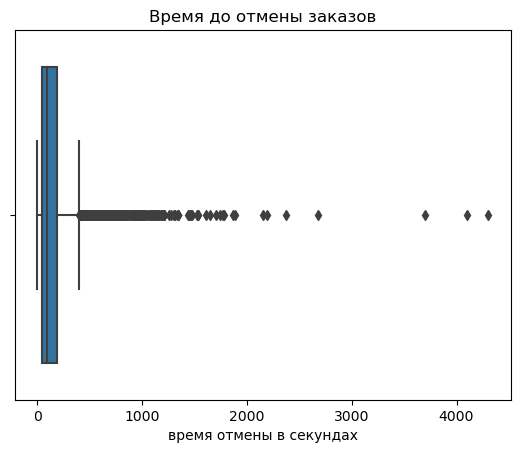

In [17]:
sns.boxplot(x=df['cancellations_time_in_seconds']).set(title='Время до отмены заказов', 
                                                       xlabel='время отмены в секундах')
;
print('Количество пропусков в столбце cancellations_time_in_seconds - ', df['cancellations_time_in_seconds'].isnull().sum())

Видим очень много выбросов и пропусков в данном столбце. 
Значения с пропусками заменим на среднее значение, а выбросы оценим в процентилях

In [18]:
a=df['cancellations_time_in_seconds'].fillna(df['cancellations_time_in_seconds'].mean())

a=np.percentile(a,95)
print('95% процентов выборки лежит в значении до -', a)

b=df.query('cancellations_time_in_seconds>435') #Проверим сколько процентов от общего датасета мы потеряем, если удалим выбросы

print(math.ceil((len(b)*100)/len(df)), '%-ов информации будет удалено') 
df['cancellations_time_in_seconds']=df['cancellations_time_in_seconds'].fillna(df['cancellations_time_in_seconds'].mean())
df=df.query('cancellations_time_in_seconds<435')

95% процентов выборки лежит в значении до - 434.25
5 %-ов информации будет удалено


Время отмены заказов в основном не превышает 435минут, остальное-выбросы (5%). Учитывая, что 5% это немного, т.е. 95% информации более корректны, можем смело удалить выбросы.

## Анализ

**1.** Для всех ли заказов нашлись офферы курьерам?

In [21]:
gr_4=df.query('order_status_key==4')
gr_9=df.query('order_status_key==9')

In [22]:
print('Число заказов без номера оффера куреьеру-',df['offer_id'].isnull().sum())
print('Число заказов без номера оффера куреьеру в заказах отмененных клиентом-',gr_4['offer_id'].isnull().sum())
print('Число заказов без номера оффера куреьеру в заказах отмененных системой-',gr_9['offer_id'].isnull().sum())

Число заказов без номера оффера куреьеру- 2978
Число заказов без номера оффера куреьеру в заказах отмененных клиентом- 1474
Число заказов без номера оффера куреьеру в заказах отмененных системой- 1504


Проверим, сколько заказов без номера оффера курьера были приняты курьером

In [23]:
gr_4=df.query('order_status_key==4')
gr_9=df.query('order_status_key==9')

null_courier_4=gr_4.query('is_courier_assigned_key==1').isnull().sum()
null_courier_9=gr_9.query('is_courier_assigned_key==1').isnull().sum()
print('Число заказов без номера оффера куреьеру в заказах отмененных клиентом, но назначенным курьером-',null_courier_4.offer_id)
print('Число заказов без номера оффера куреьеру в заказах отмененных системой, но назначенным курьером-',null_courier_9.offer_id)

Число заказов без номера оффера куреьеру в заказах отмененных клиентом, но назначенным курьером- 377
Число заказов без номера оффера куреьеру в заказах отмененных системой, но назначенным курьером- 1


В группе, где клиент отменил заказ, системой было назначено 377 курьеров, где нет данных о номере оффера курьера.

**2.** Если нашлись такие заказы, на которых не назначены курьеры, то чего больше - отмен клиентом или реджектов системы?

In [29]:
no_courier_4=gr_4.query('is_courier_assigned_key==0').isnull().sum()
print(courier_4)
no_courier_9=gr_9.query('is_courier_assigned_key==0').isnull().sum()
print(courier_9)

order_gk                            0
offer_id                         1097
order_datetime                      0
order_status_key                    0
is_courier_assigned_key             0
cancellations_time_in_seconds       0
dtype: int64
order_gk                            0
offer_id                         1503
order_datetime                      0
order_status_key                    0
is_courier_assigned_key             0
cancellations_time_in_seconds       0
dtype: int64


Пользователи отменили 1097 заказов, где курьер принял оффер, но еще не был назначен системой.

A система отменила 1503 заказов, где курьер принял оффер, но еще не был назначен системой.

In [36]:
cancel_4=len(no_courier_4)/len(gr_4)
cancel_4

0.0008861320336730173

In [37]:
cancel_9=len(no_courier_9)/len(gr_9)
cancel_9

0.0017600469345849222

**3.** Какова доля заказов с назначенным курьером среди заказов, отмененных системой?

In [33]:
courier_4=gr_4.query('is_courier_assigned_key==1')
courier_4

,order_gk,offer_id,order_datetime,order_status_key,is_courier_assigned_key,cancellations_time_in_seconds
0,3000583041974,3.000510e+11,2020-07-22 18:08:07,4,1,198.0
9,3000582891479,3.000510e+11,2020-07-22 12:07:50,4,1,46.0
12,3000582941169,3.000510e+11,2020-07-22 13:50:20,4,1,62.0
49,3000583016613,NaN,2020-07-22 16:55:28,4,1,188.0
52,3000582566041,3.000510e+11,2020-07-22 00:59:26,4,1,316.0
...,...,...,...,...,...,...
34341,3000629956882,3.000523e+11,2020-07-22 16:55:04,4,1,244.0
34361,3000599187005,3.000516e+11,2020-07-22 13:15:55,4,1,28.0
34362,3000599186936,3.000516e+11,2020-07-22 13:12:51,4,1,59.0
34371,3000599187034,3.000516e+11,2020-07-22 13:17:21,4,1,34.0


In [34]:
cancel_4=len(courier_4)/len(gr_4)
cancel_4

0.3452961157879191

In [32]:
courier_9=gr_9.query('is_courier_assigned_key==1')
courier_9

,order_gk,offer_id,order_datetime,order_status_key,is_courier_assigned_key,cancellations_time_in_seconds
3965,3000631256425,NaN,2020-07-22 16:49:55,9,1,157.892021
22370,3000630156338,3.000523e+11,2020-07-22 00:44:03,9,1,157.892021
25938,3000600112433,3.000517e+11,2020-07-22 00:12:02,9,1,157.892021


In [35]:
cancel_9=len(courier_9)/len(gr_9)
cancel_9

0.0008800234672924611

Доля заказов отмененных пользователями и назначенными курьерами доминирует 34%

**4**. Получите среднее времени до отмены (cancellations_time_in_seconds) с назначенным курьером и без, по часам.  Можно ли сделать выводы по полученной таблице?
Если необходимо - постройте график

In [59]:
df['cancellation_hours']=(df['cancellations_time_in_seconds']//3600)
df['cancellation_min']=(df['cancellations_time_in_seconds']//60)#далее ваш код
df


,order_gk,offer_id,order_datetime,order_status_key,is_courier_assigned_key,cancellations_time_in_seconds,cancellation_hours,cancellation_min
0,3000583041974,3.000510e+11,2020-07-22 18:08:07,4,1,198.000000,0.0,3.0
3,3000583116437,3.000510e+11,2020-07-22 20:57:32,4,0,128.000000,0.0,2.0
9,3000582891479,3.000510e+11,2020-07-22 12:07:50,4,1,46.000000,0.0,0.0
12,3000582941169,3.000510e+11,2020-07-22 13:50:20,4,1,62.000000,0.0,1.0
13,3000583140877,NaN,2020-07-22 21:24:45,9,0,157.892021,0.0,2.0
...,...,...,...,...,...,...,...,...
34369,3000599186906,3.000516e+11,2020-07-22 13:11:35,4,0,36.000000,0.0,0.0
34370,3000599186962,NaN,2020-07-22 13:13:55,4,0,4.000000,0.0,0.0
34371,3000599187034,3.000516e+11,2020-07-22 13:17:21,4,1,34.000000,0.0,0.0
34372,3000599187024,NaN,2020-07-22 13:16:28,4,0,6.000000,0.0,0.0


In [67]:
gr_4=df.query('order_status_key==4')
gr_9=df.query('order_status_key==9')
no_courier_4=gr_4.query('is_courier_assigned_key==0')
no_courier_9=gr_9.query('is_courier_assigned_key==0')
courier_4=gr_4.query('is_courier_assigned_key==1')
courier_9=gr_9.query('is_courier_assigned_key==1')

print('среднее времени до отмены без назначения курьера в группе клиентской отмены', no_courier_4['cancellation_min'].mean())
print('среднее времени до отмены без назначения курьера в группе системной отмены', no_courier_9['cancellation_min'].mean())
print('среднее времени до отмены с назначением курьера в группе клиентской отмены', courier_4['cancellation_min'].mean())
print('среднее времени до отмены с назначением курьера в группе системной отмены', courier_9['cancellation_min'].mean())

среднее времени до отмены без назначения курьера в группе клиентской отмены 1.2384389803744642
среднее времени до отмены без назначения курьера в группе системной отмены 2.0
среднее времени до отмены с назначением курьера в группе клиентской отмены 1.6826347305389222
среднее времени до отмены с назначением курьера в группе системной отмены 2.0


так как значения в столбце времени отмены мы взяли среднее по таблице, то на нее не смотрим, и видим, что среднее время до отмены с назначением курьера в группе клиентской отмены немного больше, чем без курьера

**5.** Постройте график распределения фейлов по часам - наблюдается ли тендеция, что в какие то часы доля той или иной категории аномально высока?
Примеры возможных категорий:

* заказы с назначенным курьером / заказы без назначенного курьера;
* заказы, отмененные системой / заказы, отменные пользователем.

In [28]:
#далее ваш код